y = W2 * ReLU(W1 * X)

SSE loss

Active set for each neuron j

In [10]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data  # Features
Y = housing.target.reshape(-1, 1)  # Target

# Standardize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Standardize target
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(Y)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Add bias term
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Parameters
n_samples, n_features = X_train.shape
hidden_dim = 200
output_dim = Y_train.shape[1]
max_iterations = 200  # Maximum number of iterations

# Initialize weights
np.random.seed(42)
W1 = np.random.randn(n_features, hidden_dim) * 0.01
W2 = np.random.randn(hidden_dim, output_dim) * 0.01

# Function to compute MSE
def compute_mse(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred) ** 2)

# Function to perform ReLU activation
def relu(Z):
    return np.maximum(0, Z)

# Initialize previous_active_sets outside the loop
previous_active_sets = [np.array([]) for _ in range(hidden_dim)]

train_mse_list = []

# Iterative procedure
for iteration in tqdm(range(max_iterations)):
    # print(f"\nIteration {iteration + 1}/{max_iterations}")

    # Forward pass
    H_train = relu(X_train @ W1)
    Y_pred_train = H_train @ W2
    train_mse = compute_mse(Y_train, Y_pred_train)

    # print(f"Training MSE: {train_mse:.6f}")

    train_mse_list.append(train_mse)

    # Assume active sets have stabilized until proven otherwise
    active_sets_stabilized = True
    stabilized_neurons = 0  # Counter for stabilized neurons

    # Temporary arrays to store updates
    W1_new = np.zeros_like(W1)
    W2_new = np.zeros_like(W2)

    # Update W1 and W2 for each neuron in the hidden layer
    for j in range(hidden_dim):
        # Active set for neuron j
        pre_activation = X_train @ W1[:, j]
        active_indices = np.where(pre_activation > 0)[0]

        # Check if active set has changed
        if not np.array_equal(active_indices, previous_active_sets[j]):
            active_sets_stabilized = False
        else:
            stabilized_neurons += 1  # Active set has not changed

        # Update previous active set
        previous_active_sets[j] = active_indices

        if len(active_indices) == 0:
            # Reinitialize weights for neuron j
            W1_new[:, j] = np.random.randn(n_features) * 0.01
            W2_new[j, :] = np.random.randn(output_dim) * 0.01
            active_sets_stabilized = False  # Active set has changed
            print(f"Reinitialized neuron {j}")
            continue  # Skip further processing for this neuron

        X_active = X_train[active_indices]
        Y_active = Y_train[active_indices]

        # Compute hidden activations excluding neuron j
        H_minus_j = relu(X_active @ W1)
        H_minus_j[:, j] = 0  # Exclude neuron j
        
        # Compute residual
        R_j = Y_active - H_minus_j @ W2

        # Perform SVD on R_j
        U, S, Vt = np.linalg.svd(R_j, full_matrices=False)

        if len(S) == 0:
            # If SVD fails due to insufficient data
            W1_new[:, j] = W1[:, j]
            W2_new[j, :] = W2[j, :]
            continue

        sigma_1 = S[0]
        u_1 = U[:, 0]
        v_1 = Vt[0, :]

        # Update weights
        w2_j_new = v_1 * np.sqrt(sigma_1)
        # Solve for w1_j: X_active @ w1_j = u_1 * sqrt(sigma_1)
        w1_j_new = np.linalg.pinv(X_active) @ (u_1 * np.sqrt(sigma_1))

        W1_new[:, j] = w1_j_new
        W2_new[j, :] = w2_j_new

    # After processing all neurons, update W1 and W2
    W1 = W1_new.copy()
    W2 = W2_new.copy()

    # After updating W1, recompute W2 using all data
    H_train = relu(X_train @ W1)
    # To avoid singular matrix, add a small regularization term
    regularization = 1e-8 * np.eye(H_train.shape[1])
    W2 = np.linalg.pinv(H_train.T @ H_train + regularization) @ H_train.T @ Y_train

    # Print the number of stabilized neurons
    # print(f"Number of stabilized neurons: {stabilized_neurons}/{hidden_dim}")

    # Check for convergence
    if active_sets_stabilized:
        print("Active sets have stabilized. Stopping iterations.")
        break

# Final training and testing MSE
H_train = relu(X_train @ W1)
Y_pred_train = H_train @ W2
final_train_mse = compute_mse(Y_train, Y_pred_train)

H_test = relu(X_test @ W1)
Y_pred_test = H_test @ W2
final_test_mse = compute_mse(Y_test, Y_pred_test)

print("\nFinal Results:")
print(f"Final Training MSE: {final_train_mse:.6f}")
print(f"Final Testing MSE: {final_test_mse:.6f}")

Y_train_unscaled = scaler_Y.inverse_transform(Y_train)
Y_pred_train_unscaled = scaler_Y.inverse_transform(Y_pred_train)

Y_test_unscaled = scaler_Y.inverse_transform(Y_test)
Y_pred_test_unscaled = scaler_Y.inverse_transform(Y_pred_test)

unscaled_train_mse = compute_mse(Y_train_unscaled, Y_pred_train_unscaled)
unscaled_test_mse = compute_mse(Y_test_unscaled, Y_pred_test_unscaled)
print(f"Unscaled Training MSE: {unscaled_train_mse:.6f}")
print(f"Unscaled Testing MSE: {unscaled_test_mse:.6f}")


100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


Final Results:
Final Training MSE: 0.175777
Final Testing MSE: 0.246739
Unscaled Training MSE: 0.234055
Unscaled Testing MSE: 0.328545


[199 198 197 196 195 194 193 192 191 190]
0.17580030452647527
0.17580030452647527


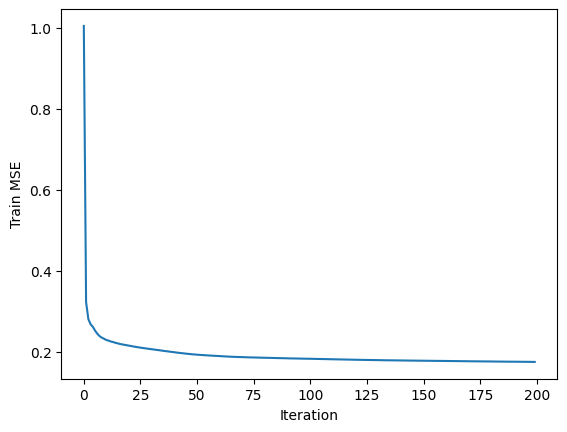

In [11]:
top_10_min_indexes = np.argsort(train_mse_list)[:10]
print(top_10_min_indexes)
print(train_mse_list[top_10_min_indexes[0]])
print(train_mse_list[-1])


import matplotlib.pyplot as plt

plt.plot(train_mse_list)
plt.xlabel("Iteration")
plt.ylabel("Train MSE")
plt.show()

In [12]:
W1

array([[ 0.14042382,  0.31071095,  0.14849487, ..., -0.03675438,
         0.32213713, -0.26638487],
       [ 0.02389043,  0.03924386,  0.02078468, ...,  0.07165531,
         0.04540645, -0.04764839],
       [-0.07248031, -0.15245733, -0.0272582 , ..., -0.1327242 ,
        -0.13215827,  0.10682016],
       ...,
       [-0.15537109, -0.34354155, -0.18125494, ...,  0.0859442 ,
        -0.33031683,  0.25085635],
       [-0.15185841, -0.33205959, -0.19860078, ...,  0.05976299,
        -0.3202574 ,  0.24411903],
       [-0.02097345,  0.01017074,  0.01465398, ...,  0.50719493,
         0.00807088,  0.00348251]])

In [13]:
W2

array([[  13.97519993],
       [ -25.12366225],
       [  17.31748907],
       [ -24.90062636],
       [  16.27491918],
       [ -14.08928954],
       [ -11.17263241],
       [ -17.03494171],
       [   6.96967217],
       [ -37.90546097],
       [  11.01915397],
       [  30.7419622 ],
       [ -21.0216189 ],
       [  47.04992543],
       [  19.06031802],
       [  38.12226895],
       [ -21.6185498 ],
       [  15.2465901 ],
       [   9.40634793],
       [  19.9892316 ],
       [  -6.29230354],
       [ -18.36681776],
       [  26.99452741],
       [  12.55448714],
       [ -34.05654015],
       [ -20.66611399],
       [ -17.11702895],
       [  29.03822118],
       [ -16.1396529 ],
       [  15.05671213],
       [  26.33429351],
       [  10.06273166],
       [  -9.53524665],
       [  19.64436697],
       [  -9.1724934 ],
       [ -10.68838238],
       [  15.94456016],
       [  22.2809466 ],
       [ -11.00393382],
       [ -19.98240504],
       [  26.2619248 ],
       [-101.696

In [14]:
train_mse_list[:20]

[np.float64(1.0043928569151301),
 np.float64(0.3233722244790414),
 np.float64(0.2813637090187754),
 np.float64(0.2684607329847263),
 np.float64(0.26229541331322526),
 np.float64(0.25268437500147695),
 np.float64(0.24500711115810825),
 np.float64(0.23916763054193235),
 np.float64(0.23551055017992997),
 np.float64(0.23270160325756933),
 np.float64(0.22975792396505898),
 np.float64(0.2281813178354748),
 np.float64(0.22597376195687854),
 np.float64(0.22475853431332987),
 np.float64(0.22275007014901463),
 np.float64(0.2215578036575625),
 np.float64(0.2199542991683131),
 np.float64(0.21889443253481072),
 np.float64(0.21756270124005497),
 np.float64(0.21670493672932342)]

Select random neuron and update it

In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data  # Features
Y = housing.target.reshape(-1, 1)  # Target

# Standardize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Standardize target
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(Y)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Add bias term
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Parameters
n_samples, n_features = X_train.shape
hidden_dim = 200
output_dim = Y_train.shape[1]
max_iterations = 10000  # Maximum number of iterations

# Initialize weights
np.random.seed(42)
W1 = np.random.randn(n_features, hidden_dim) * 0.01
W2 = np.random.randn(hidden_dim, output_dim) * 0.01

# Function to compute MSE
def compute_mse(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred) ** 2)

# Function to perform ReLU activation
def relu(Z):
    return np.maximum(0, Z)

# Initialize previous_active_sets outside the loop
previous_active_sets = [np.array([]) for _ in range(hidden_dim)]
# Initialize active_sets_stabilized array
active_sets_stabilized = np.zeros(hidden_dim, dtype=bool)

train_mse_list = []

# Iterative procedure
for iteration in tqdm(range(max_iterations)):
    # Forward pass
    H_train = relu(X_train @ W1)
    Y_pred_train = H_train @ W2
    train_mse = compute_mse(Y_train, Y_pred_train)

    train_mse_list.append(train_mse)

    # Randomly select a neuron to update
    j = np.random.randint(0, hidden_dim)

    # Active set for neuron j
    pre_activation = X_train @ W1[:, j]
    active_indices = np.where(pre_activation > 0)[0]

    # Check if active set has changed
    if not np.array_equal(active_indices, previous_active_sets[j]):
        active_sets_stabilized[j] = False
    else:
        active_sets_stabilized[j] = True  # Active set has not changed

    # Update previous active set
    previous_active_sets[j] = active_indices

    if len(active_indices) == 0:
        # Reinitialize weights for neuron j
        W1[:, j] = np.random.randn(n_features) * 0.01
        W2[j, :] = np.random.randn(output_dim) * 0.01
        active_sets_stabilized[j] = False  # Active set has changed
        print(f"Reinitialized neuron {j}")
        continue  # Skip further processing for this neuron

    X_active = X_train[active_indices]
    Y_active = Y_train[active_indices]

    # Compute hidden activations excluding neuron j
    H_minus_j = relu(X_active @ W1)
    H_minus_j[:, j] = 0  # Exclude neuron j

    # Compute residual
    R_j = Y_active - H_minus_j @ W2

    # Perform SVD on R_j
    U, S, Vt = np.linalg.svd(R_j, full_matrices=False)

    if len(S) == 0:
        # If SVD fails due to insufficient data
        continue

    sigma_1 = S[0]
    u_1 = U[:, 0]
    v_1 = Vt[0, :]

    # Update weights
    w2_j_new = v_1 * np.sqrt(sigma_1)
    # Solve for w1_j: X_active @ w1_j = u_1 * sqrt(sigma_1)
    w1_j_new = np.linalg.pinv(X_active) @ (u_1 * np.sqrt(sigma_1))

    W1[:, j] = w1_j_new
    W2[j, :] = w2_j_new

    # After updating W1, recompute W2 using all data
    H_train = relu(X_train @ W1)
    # To avoid singular matrix, add a small regularization term
    regularization = 1e-8 * np.eye(H_train.shape[1])
    W2 = np.linalg.pinv(H_train.T @ H_train + regularization) @ H_train.T @ Y_train

    # Check for convergence
    if np.all(active_sets_stabilized):
        print("All active sets have stabilized. Stopping iterations.")
        break

# Final training and testing MSE
H_train = relu(X_train @ W1)
Y_pred_train = H_train @ W2
final_train_mse = compute_mse(Y_train, Y_pred_train)

H_test = relu(X_test @ W1)
Y_pred_test = H_test @ W2
final_test_mse = compute_mse(Y_test, Y_pred_test)

print("\nFinal Results:")
print(f"Final Training MSE: {final_train_mse:.6f}")
print(f"Final Testing MSE: {final_test_mse:.6f}")

Y_train_unscaled = scaler_Y.inverse_transform(Y_train)
Y_pred_train_unscaled = scaler_Y.inverse_transform(Y_pred_train)

Y_test_unscaled = scaler_Y.inverse_transform(Y_test)
Y_pred_test_unscaled = scaler_Y.inverse_transform(Y_pred_test)

unscaled_train_mse = compute_mse(Y_train_unscaled, Y_pred_train_unscaled)
unscaled_test_mse = compute_mse(Y_test_unscaled, Y_pred_test_unscaled)
print(f"Unscaled Training MSE: {unscaled_train_mse:.6f}")
print(f"Unscaled Testing MSE: {unscaled_test_mse:.6f}")


100%|██████████| 10000/10000 [04:05<00:00, 40.74it/s]


Final Results:
Final Training MSE: 0.160420
Final Testing MSE: 0.221148
Unscaled Training MSE: 0.213607
Unscaled Testing MSE: 0.294470


[9620 9656 9655 9654 9653 9652 9651 9509 9508 9507]
0.15983422768656663
0.16036152682601448


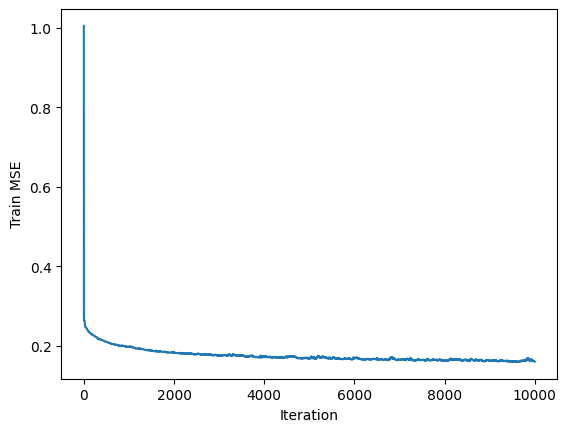

In [7]:
top_10_min_indexes = np.argsort(train_mse_list)[:10]
print(top_10_min_indexes)
print(train_mse_list[top_10_min_indexes[0]])
print(train_mse_list[-1])


import matplotlib.pyplot as plt

plt.plot(train_mse_list)
plt.xlabel("Iteration")
plt.ylabel("Train MSE")
plt.show()

In [5]:
W1

array([[-0.01254068, -0.004249  , -0.01176104, ...,  0.00598167,
        -0.00472913, -0.02160656],
       [ 0.01135335,  0.01581834, -0.03454471, ...,  0.00905083,
         0.00735146,  0.04818801],
       [ 0.02834255, -0.01501237, -0.01105315, ..., -0.01158951,
         0.03047652, -0.01329387],
       ...,
       [ 0.06655834, -0.01867102,  0.01361466, ...,  0.01233742,
        -0.03876178, -0.02452196],
       [ 0.10667334,  0.0085002 , -0.01756744, ...,  0.02899097,
         0.00033464, -0.02251346],
       [ 0.0053719 ,  0.04555767,  0.01654871, ...,  0.00273272,
        -0.03019259,  0.01587899]])

In [6]:
W2

array([[  6.2258022 ],
       [ 10.2480666 ],
       [ -9.17566604],
       [  7.28532264],
       [ -9.4029193 ],
       [ -7.76005426],
       [-10.02606051],
       [-11.47894249],
       [ -5.77168447],
       [  7.56184519],
       [ -9.78527214],
       [ -7.34688255],
       [ 10.22942035],
       [ -6.62114879],
       [  6.36433014],
       [  7.65971552],
       [ -6.10789983],
       [ -9.49253843],
       [-12.48562177],
       [ -3.57773253],
       [  6.08439821],
       [ 11.13418182],
       [ -5.91572857],
       [  7.95802294],
       [-16.18894121],
       [-18.48365793],
       [ -9.25267064],
       [  6.72540618],
       [-10.2020554 ],
       [  9.63638684],
       [ -7.01797676],
       [ -5.83312955],
       [  6.47697043],
       [ 13.57487037],
       [-10.53193617],
       [-13.14942078],
       [  7.28769065],
       [-11.45963327],
       [  8.06615416],
       [-11.1131404 ],
       [-11.59380255],
       [ -7.6292186 ],
       [ -8.45211118],
       [  6

gradient descent

/Users/denysstar17/Desktop/projects/close-form-ReLU/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/800], Loss: 0.2758, LR: 0.001000
Epoch [10/800], Loss: 0.2555, LR: 0.001000
Epoch [15/800], Loss: 0.2413, LR: 0.001000
Epoch [20/800], Loss: 0.2738, LR: 0.001000
Epoch [25/800], Loss: 0.2243, LR: 0.001000
Epoch [30/800], Loss: 0.2250, LR: 0.001000
Epoch [35/800], Loss: 0.2190, LR: 0.001000
Epoch [40/800], Loss: 0.2148, LR: 0.001000
Epoch [45/800], Loss: 0.2138, LR: 0.001000
Epoch [50/800], Loss: 0.2121, LR: 0.001000
Epoch [55/800], Loss: 0.2331, LR: 0.001000
Epoch [60/800], Loss: 0.2097, LR: 0.001000
Epoch [65/800], Loss: 0.2062, LR: 0.001000
Epoch [70/800], Loss: 0.2072, LR: 0.001000
Epoch [75/800], Loss: 0.2002, LR: 0.001000
Epoch [80/800], Loss: 0.2077, LR: 0.001000
Epoch [85/800], Loss: 0.2171, LR: 0.001000
Epoch [90/800], Loss: 0.2003, LR: 0.001000
Epoch [95/800], Loss: 0.1967, LR: 0.001000
Epoch [100/800], Loss: 0.2086, LR: 0.001000
Epoch [105/800], Loss: 0.1925, LR: 0.001000
Epoch [110/800], Loss: 0.1921, LR: 0.001000
Epoch [115/800], Loss: 0.1933, LR: 0.001000
Epoch [1

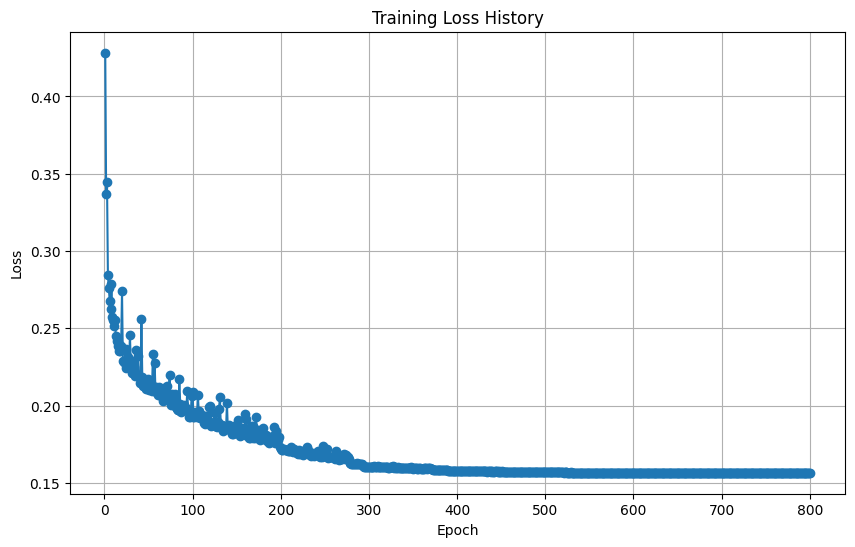


Train MSE (Scaled): 0.1565
Train MSE (Unscaled): 0.2084

Test MSE (Scaled): 0.2045
Test MSE (Unscaled): 0.2723


In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data  # Features
Y = housing.target.reshape(-1, 1)  # Target

# Standardize features
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Standardize target
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(Y)

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # Hidden layer
        self.relu = nn.ReLU()                           # ReLU activation
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model instantiation
input_size = X_train.shape[1]  # Number of features
hidden_size = 200              # Number of neurons in hidden layer
output_size = 1                # Output size for regression

model = Net(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler based on training loss change
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
num_epochs = 800
train_losses = []  # To store training loss history


start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Scheduler step with training loss
    scheduler.step(epoch_loss)
    
    # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}")
        

train_time = time.time() - start_time

print(f"Training time: {train_time}")

# Plot training loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

# Evaluation function
def evaluate(model, loader, scaler_Y, dataset_type="Train"):
    model.eval()
    with torch.no_grad():
        total_loss_scaled = 0.0
        predictions_scaled = []
        actuals_scaled = []
        for X_batch, Y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            total_loss_scaled += loss.item() * X_batch.size(0)
            predictions_scaled.append(outputs)
            actuals_scaled.append(Y_batch)
        mse_scaled = total_loss_scaled / len(loader.dataset)

        # Concatenate all batches
        predictions_scaled = torch.cat(predictions_scaled, dim=0).numpy()
        actuals_scaled = torch.cat(actuals_scaled, dim=0).numpy()

        # Inverse transform to original scale
        predictions_unscaled = scaler_Y.inverse_transform(predictions_scaled)
        actuals_unscaled = scaler_Y.inverse_transform(actuals_scaled)

        # Calculate unscaled MSE
        mse_unscaled = np.mean((predictions_unscaled - actuals_unscaled) ** 2)

        print(f"\n{dataset_type} MSE (Scaled): {mse_scaled:.4f}")
        print(f"{dataset_type} MSE (Unscaled): {mse_unscaled:.4f}")

    return mse_scaled, mse_unscaled

# Evaluate on training data
train_mse_scaled, train_mse_unscaled = evaluate(model, train_loader, scaler_Y, dataset_type="Train")

# Evaluate on test data
test_mse_scaled, test_mse_unscaled = evaluate(model, test_loader, scaler_Y, dataset_type="Test")


In [20]:
for x in model.parameters():
    print(x)

Parameter containing:
tensor([[-0.5003, -0.0337,  0.2308,  ...,  0.0317, -0.2551,  0.2443],
        [-0.8071, -0.1036, -0.2706,  ..., -1.3330, -0.4568, -0.4309],
        [-0.4517, -0.0168, -0.0278,  ...,  0.0977,  0.8777, -0.2131],
        ...,
        [ 0.4651,  0.5636,  0.1821,  ...,  0.0547, -0.0876, -0.0624],
        [-0.0400, -0.0162,  0.0614,  ...,  0.0041, -0.1649, -0.0822],
        [ 0.0112, -0.0976,  0.2575,  ..., -0.0737,  0.4510, -0.8489]],
       requires_grad=True)
Parameter containing:
tensor([-0.7996, -0.2867, -1.3242, -0.0516, -0.2790,  0.1014, -0.3016,  0.0339,
        -0.0088, -0.1339,  0.2171, -0.2742, -0.4980, -0.3878, -0.2074,  0.3382,
        -0.4685, -0.0101,  0.7102, -0.6650,  0.0473, -0.0219, -0.2505, -0.3774,
        -0.8011, -0.4117, -0.4835, -0.5683, -0.7141, -0.7110, -0.2863, -0.9607,
        -0.2139,  0.1526, -0.4456, -0.1639, -0.6218, -0.5738, -0.4661,  0.1634,
        -0.4344, -0.0266,  0.5537, -0.6690, -0.1563, -0.5315, -0.1475, -0.6825,
         0.6292